<a id='Table of Contents'></a><h1>Table of Contents</h1>

- <a href='#introduction'>Introduction</a> 
- <a href='#imports'>Import and install required libraries</a>  
- <a href='#set_fitting'>Setting of fitting</a>  
- <a href='#run_fit'>Running the fit</a>  
- <a href='#results'>Showing the results</a> 

(<a href='#Table of Contents'>Top</a>)<a id='introduction'></a><h2>Introduction</h2>

<div class="alert alert-block alert-info">
The objective of this notebook is to show how to use the <b>water_teixeira</b> model and fit the data using lmfit.
</div>

The data are two sets of water data measured at IN5 (ILL) at 5 &#x212B;.

**Reference:** J. Qvist, H. Schober and B. Halle, *J. Chem. Phys.* **134**, 144508 (2011)

(<a href='#Table of Contents'>Top</a>)<a id='imports'></a><h2> Import python modules for plotting, fitting... </h2>

In [49]:
# Imported required libraries
from __future__ import print_function
import sys
import os

import h5py
from scipy.integrate import simps

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

# for interactive plots
import panel
panel.extension()
import panel.widgets as pnw

# the following two lines are to remove the warning about too many figures open simultaneously
from matplotlib import rcParams
rcParams.update({'figure.max_open_warning': 0})

In [50]:
# install lmfit (if not already installed)
import pkgutil
if not pkgutil.find_loader("lmfit"):
    lmfitY = pnw.Button(name='Yes', button_type='success')
    lmfitN = pnw.Button(name='No', button_type='danger')
    choice_installation = panel.Column("Do you want to install lmfit?", panel.Row(lmfitY, lmfitN))
    display(choice_installation)

<h3> install lmfit (if not already installed) </h3>

In [51]:
if not pkgutil.find_loader("lmfit"):
    if lmfitY.clicks>0:
         !{sys.executable} -m pip install lmfit
    elif lmfitN.clicks>0:
        print("You will not be able to run some of the remaining parts of this notebook")

In [52]:
# required imports from lmfit
from lmfit import Model, Parameters, CompositeModel
from scipy.interpolate import interp1d

<h3> install QENSmodels (if not already installed) </h3>

In [53]:
if not pkgutil.find_loader("QENSmodels"):
    buttonY = pnw.Button(name='Yes', button_type='success')
    buttonN = pnw.Button(name='No', button_type='danger')
    choice_installation = panel.Column("Do you want to install the QENSmodels' library?", panel.Row(buttonY, buttonN))
    display(choice_installation)

In [54]:
if not pkgutil.find_loader("QENSmodels"):
    if buttonY.clicks>0:
        !{sys.executable} -m pip install git+https://github.com/QENSlibrary/QENSmodels#egg=QENSmodels
    elif buttonN.clicks>0:
        print("You will not be able to run some of the remaining parts of this notebook")

 (<a href='#Table of Contents'>Top</a>)<a id='set_fitting'></a><h2>Setting of fitting </h2>
<h3> import reference data and select energy range</h3>

In [55]:
path_to_data = './data/'

with h5py.File(path_to_data + 'H2O_293K_5A.hdf') as f:
    data_in = f['entry1']
    w = data_in['data1']
    x = w['X'][()]  # energy or time values
    unit_w=w['X'].attrs['long_name']
    unit_q=w['Y'].attrs['long_name']
    y = w['DATA'][()] # intensities
    e = w['errors'][()]  # errors for the intensities
    # Obtain the momentum transfer values
    q = w['Y'][()]
    data_5A = dict(q=q, x=x, y=y, e=e)

In [56]:
# number of spectra (i.e. number of different q-values)
nb_q_values = len(data_5A['q'])

<h3> display units of input data </h3>

In [9]:
print("The names and units of `w` ( `x`axis) and `q` are: {} and {}, respectively.".format(str(unit_w[0], 'utf-8'), str(unit_q[0], 'utf-8')))

The names and units of `w` ( `x`axis) and `q` are:  Energy Transfer (meV) and Wavevector Transfer (A!U-1!N), respectively.


<h3> import resolution data and normalize (unit area) </h3>

In [10]:
path_to_data = './data/'

with h5py.File(path_to_data + 'V_273K_5A.hdf') as f:
    data = f['entry1']
    w = data['data1']  
    res_5A_x = w['X'][()]
    res_5A = np.transpose(w['DATA'][()])

# Force resolution function to have unit area    
for i in range(len(data_5A['q'])):
    area = simps(res_5A[:,i], data_5A['x'])
    res_5A[:,i] /= area

<h3> Mask data according to energy range and filter negative error </h3>

In [11]:
# Filter according to energy-range
mask = np.intersect1d(np.where(data_5A['x']>-1.), np.where(data_5A['x']<1.))

f_5A_mask = dict()
f_5A_mask['x'] = np.asarray([data_5A['x'][mask] for i in range(nb_q_values)])
f_5A_mask['y'] = np.asarray([y[mask] for y in data_5A['y']])
f_5A_mask['e'] = np.asarray([e[mask] for e in data_5A['e']])

# Select resolution according to energy range
res_5A_x=res_5A_x[mask]
res_5A=res_5A[mask,:]

In [12]:
# Filter according to negative error values 
# resolution
resol_5A_x = np.asarray([res_5A_x[np.where(f_5A_mask['e'][i] > 0.0)] for i in range(nb_q_values)])
resol_5A = np.asarray([res_5A[np.where(f_5A_mask['e'][i] > 0.0), i][0] for i in range(nb_q_values)])

# data
f_5A = dict()
f_5A['x'] = np.asarray([x[np.where(f_5A_mask['e'][i] > 0.0)] for i, x in enumerate(f_5A_mask['x'])])
f_5A['y'] = np.asarray([y[np.where(f_5A_mask['e'][i] > 0.0)] for i, y in enumerate(f_5A_mask['y'])])
f_5A['e'] = np.asarray([e[np.where(f_5A_mask['e'][i] > 0.0)] for i, e in enumerate(f_5A_mask['e'])])

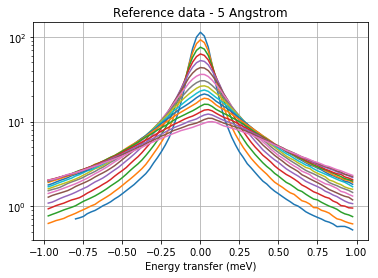

In [13]:
# plot experimental data
f, ax = plt.subplots()
[ax.semilogy(f_5A['x'][i], f_5A['y'][i]) for i in range(nb_q_values)]
ax.grid()
ax.set_xlabel(r'Energy transfer (meV)') 
ax.set_title('Reference data - 5 Angstrom') 
plt.show()

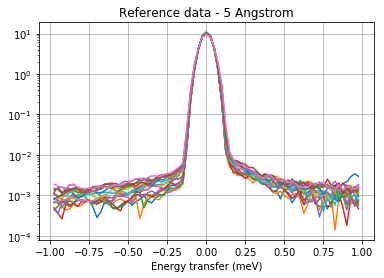

In [28]:
# plot experimental data
f, ax = plt.subplots()
[ax.semilogy(resol_5A_x[i], resol_5A[i]) for i in range(nb_q_values)]
ax.grid()
ax.set_xlabel(r'Energy transfer (meV)') 
ax.set_title('Resolution function - 5 Angstrom') 
plt.show()

<h3> create function for instrument resolution data (cubic interpolation between tabulated data points) </h3>

In [29]:
f_interp = [interp1d(resol_5A_x[i], resol_5A[i]/np.sum(resol_5A[i]), kind='cubic', bounds_error=False, fill_value='extrapolate') for i in range(nb_q_values)]

def irf_gate(w, spectrum_nb=0):
    """ Function defined from the interpolation of instrument resolution data 
    Used to define fitting model and plot """ 
    return f_interp[spectrum_nb](w)

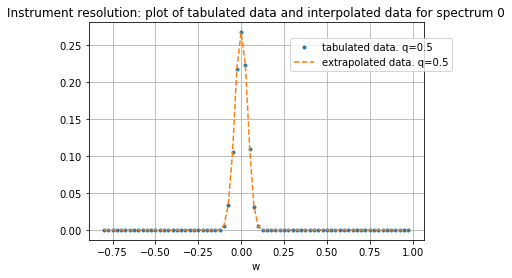

In [37]:
# check interpolation for first spectrum of resolution function: plot tabulated data and interpolated data
indx = 0

plt.plot(resol_5A_x[indx], resol_5A[indx]/np.sum(resol_5A[indx]), '.', label='tabulated data. q={:.2}'.format(data_5A['q'][indx]))
plt.plot(f_5A['x'][indx], irf_gate(f_5A['x'][indx], indx), '--', label='extrapolated data. q={:.2}'.format(data_5A['q'][indx]))

plt.legend(bbox_to_anchor=(1.1, .95))
plt.xlabel('w')
plt.title('Instrument resolution: plot of tabulated data and interpolated data for spectrum {}'.format(indx))
plt.grid()
plt.show()

<h3> create fitting model </h3>

In [16]:
import QENSmodels

In [17]:
# Create convolution function 
# code from https://lmfit.github.io/lmfit-py/model.html

def convolve(arr, kernel):
    # simple convolution of two arrays
    npts = min(len(arr), len(kernel))
    pad  = np.ones(npts)
    tmp  = np.concatenate((pad*arr[0], arr, pad*arr[-1]))
    
    out  = np.convolve(tmp, kernel, mode='valid')
    noff = int((len(out) - npts)/2)
    return out[noff:noff+npts]

In [18]:
model = CompositeModel(Model(irf_gate), Model(QENSmodels.sqwWaterTeixeira), convolve) 

print('Names of parameters:', model.param_names)
print('Independent variable(s):', model.independent_vars)

# Define boundaries for parameters to be refined
model.set_param_hint('scale', min=0, max=100)
model.set_param_hint('center', min=-0.1, max=0.1)
model.set_param_hint('D', min=0.05, max=0.25)
model.set_param_hint('resTime', min=0, max=1)
model.set_param_hint('radius', min=0.9, max=1.1)
model.set_param_hint('DR', min=0, max=1)

# Fix some of the parameters
model.set_param_hint('q', vary=False)
model.set_param_hint('spectrum_nb', vary=False)

params = model.make_params()

Names of parameters: ['spectrum_nb', 'q', 'DR', 'radius', 'resTime', 'D', 'center', 'scale']
Independent variable(s): ['w']


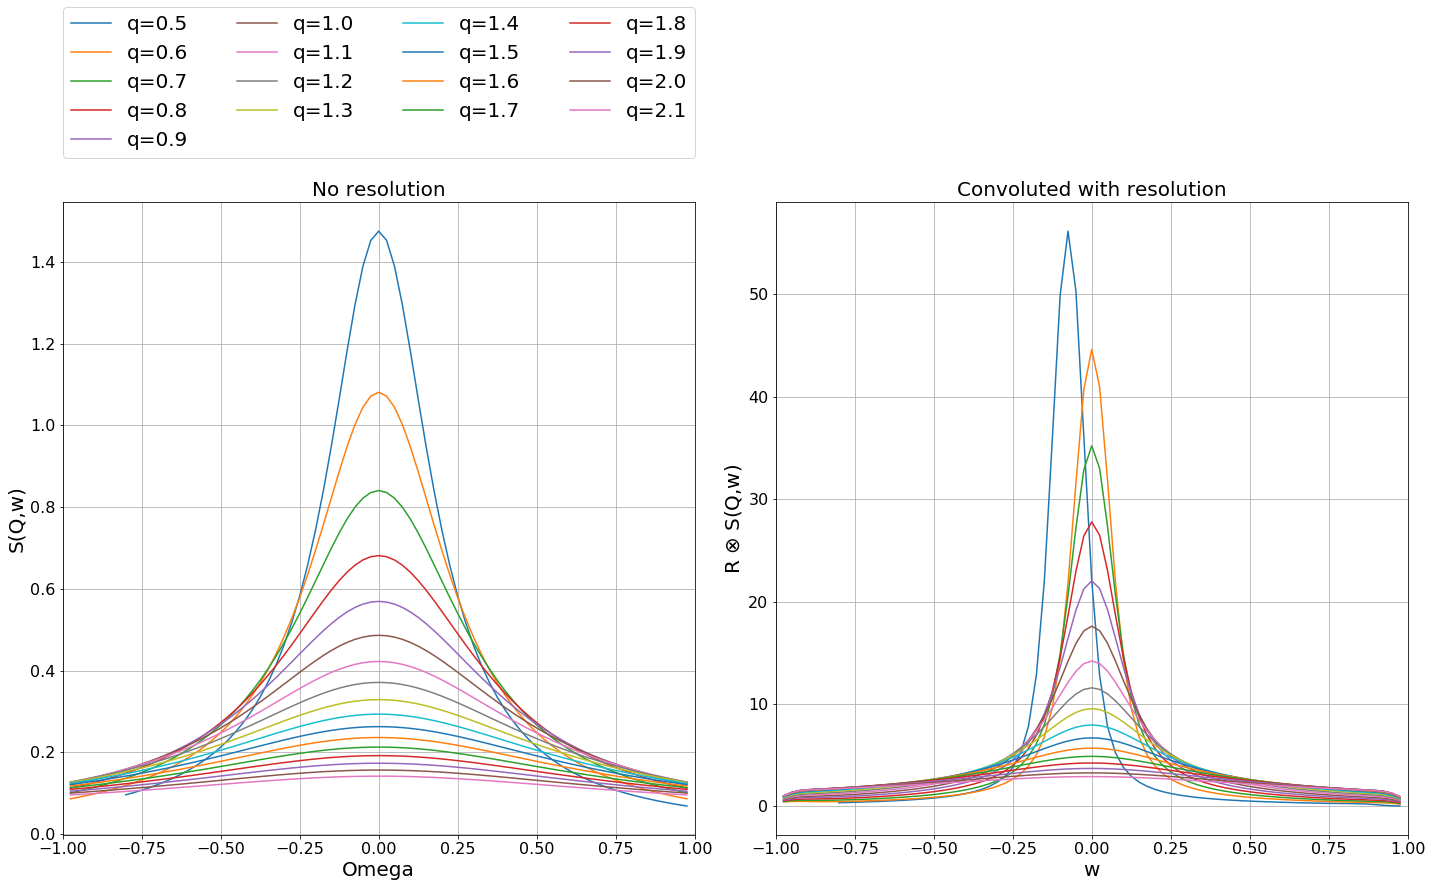

In [41]:
# Plot of the fitting models without and convoluted with the resolution function
# THe values of the parameters are specified below. Therefore they could be different from those used in the fitting.

fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(121)
for i in range(nb_q_values):
    xx = f_5A['x'][i]
    ax1.plot(xx, QENSmodels.sqwWaterTeixeira(xx, data_5A['q'][i], scale=1, center=0, D=1, resTime=1, radius=1, DR=1), label='q={:.2}'.format(data_5A['q'][i]))  
ax1.grid(True)
plt.title('No resolution', fontsize=20)
ax1.set_xlabel('Omega', fontsize=20)
ax1.set_ylabel('S(Q,w)', fontsize=20)
ax1.set_xlim(-1,1)
ax1.tick_params(labelsize=16)

ax2 = fig.add_subplot(122)
for i in range(nb_q_values):
    params_plot = model.make_params(nb_spectrum=i, 
                                    q=data_5A['q'][i],
                                    scale=10.,
                                    center=0.,
                                    D=0.13,
                                    resTime=0.1,
                                    radius=1.,
                                    DR=0.3)    
    xx = f_5A['x'][i]
    ax2.plot(xx, model.eval(params_plot, w=xx))

ax2.grid(True)
ax2.set_xlabel('w', fontsize=20)
plt.title('Convoluted with resolution', fontsize=20)
ax2.set_ylabel('R $\otimes$ S(Q,w)', fontsize=20)
ax2.set_xlim(-1,1)
ax2.tick_params(labelsize=16)

plt.tight_layout()
ax1.legend(bbox_to_anchor=(0., 1.07, 1., .102), loc='lower right', ncol=4, mode="expand", borderaxespad=0., fontsize=20)

plt.show()   

(<a href='#Table of Contents'>Top</a>)<a id='run_fit'></a><h2>Running the fit</h2>

Run the fit using `lmfit`.

In [42]:
initial_parameters_values = [10., 0., 0.13, 0.1, 1., 0.3]

result_fit = [None,] * nb_q_values  # store fits for all spectra
for i in range(nb_q_values):
    params = model.make_params(nb_spectrum=i, q=data_5A['q'][i],
                               scale=initial_parameters_values[0], 
                               center=initial_parameters_values[1], 
                               D=initial_parameters_values[2],
                               resTime=initial_parameters_values[3],
                               radius=initial_parameters_values[4],
                               DR=initial_parameters_values[5])
    
    # Q-independent parameters
    if i==0:
        D_value = params['D'].value
        resTime_value = params['resTime'].value
        radius_value = params['radius'].value
        DR_value = params['DR'].value
    else:
        params['D'].set(value=D_value)
        params['resTime'].set(value=resTime_value)
        params['radius'].set(value=radius_value)
        params['DR'].set(value=DR_value)

    result_fit[i] = model.fit(f_5A['y'][i], params,w=f_5A['x'][i])

(<a href='#Table of Contents'>Top</a>)<a id='results'></a><h2>Showing the results </h2>
using methods implemented in `lmfit`

In [44]:
# display result
for i in range(nb_q_values):
    print('Result of fit {}:\n'.format(i),result_fit[i].fit_report())

Result of fit 0:
 [[Model]]
    (Model(irf_gate) <function convolve at 0x11ebd2048> Model(sqwWaterTeixeira))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 72
    # variables        = 6
    chi-square         = 180.999673
    reduced chi-square = 2.74241929
    Akaike info crit   = 78.3716957
    Bayesian info crit = 92.0316924
[[Variables]]
    spectrum_nb:  0 (fixed)
    q:            0.5 (fixed)
    DR:           0.06474236 (init = 0.3)
    radius:       1.00000000 (init = 1)
    resTime:      0.10000000 (init = 0.1)
    D:            0.13000000 (init = 0.13)
    center:       0.08062416 (init = 0)
    scale:        19.8229682 (init = 10)

Result of fit 1:
 [[Model]]
    (Model(irf_gate) <function convolve at 0x11ebd2048> Model(sqwWaterTeixeira))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 21
    # data points      = 79
    # variables        = 6
    chi-square         = 1239.81233
    reduced

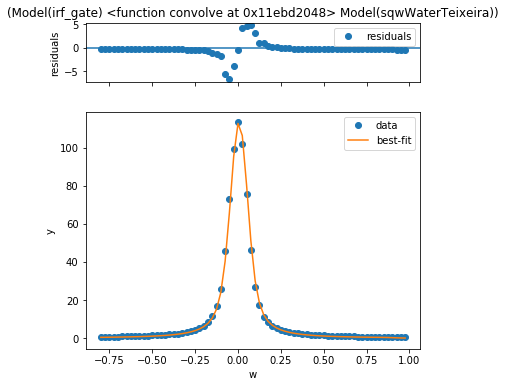

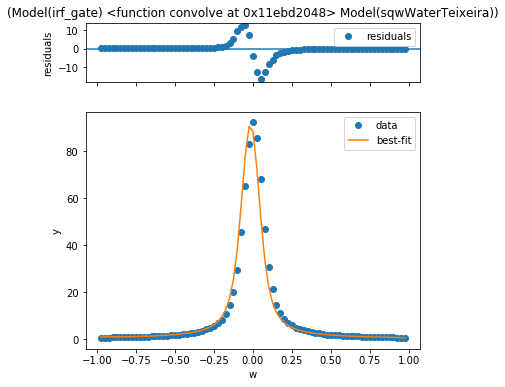

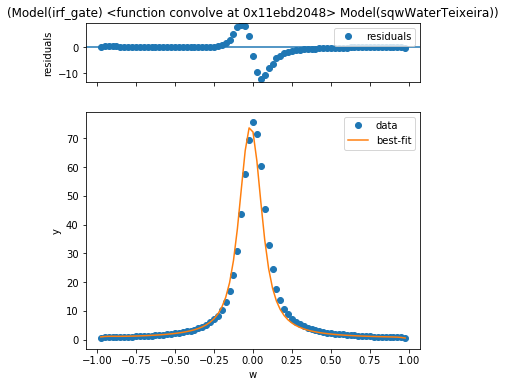

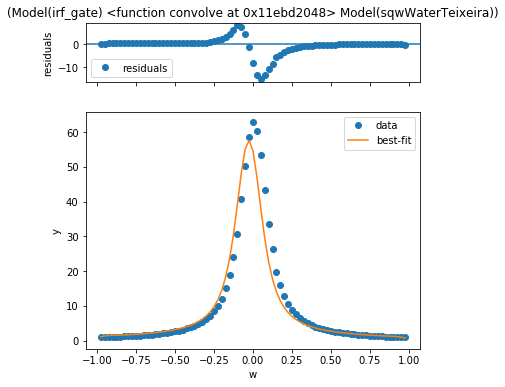

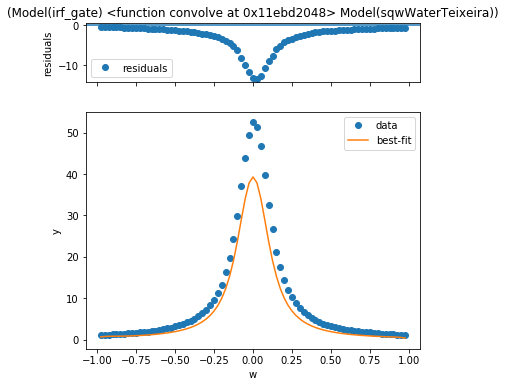

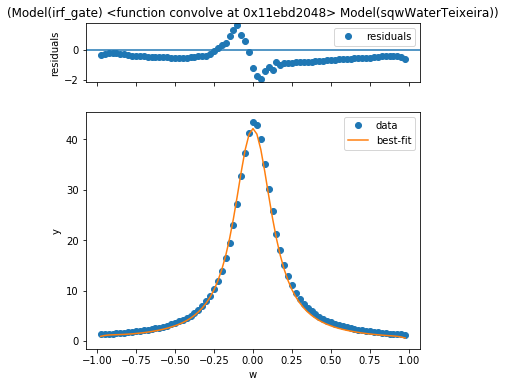

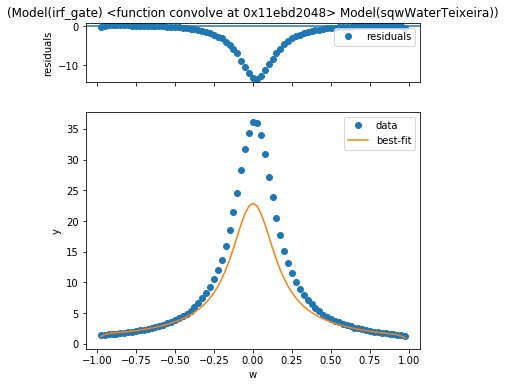

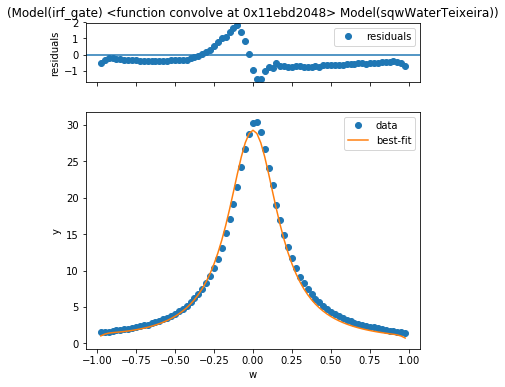

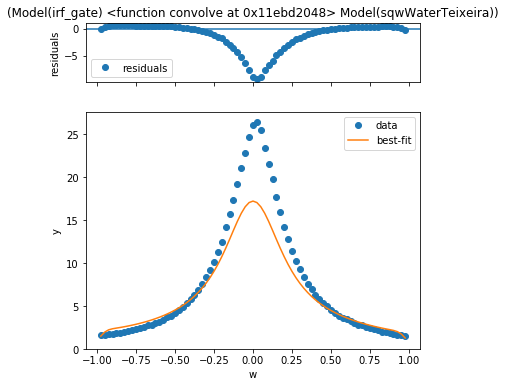

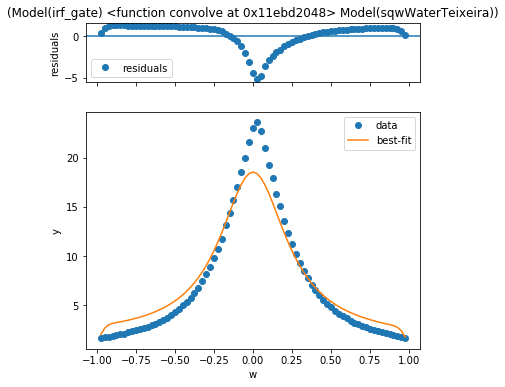

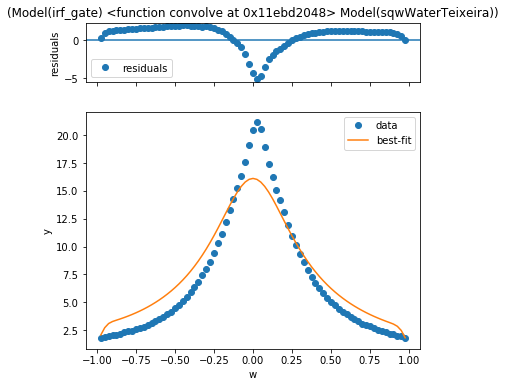

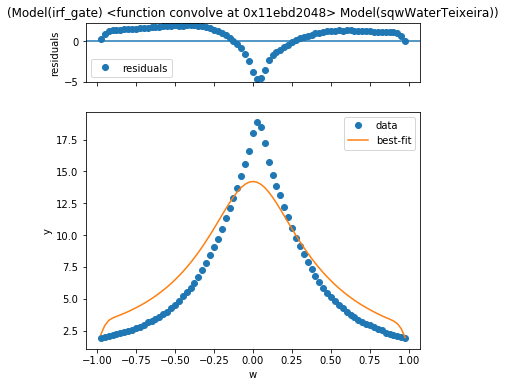

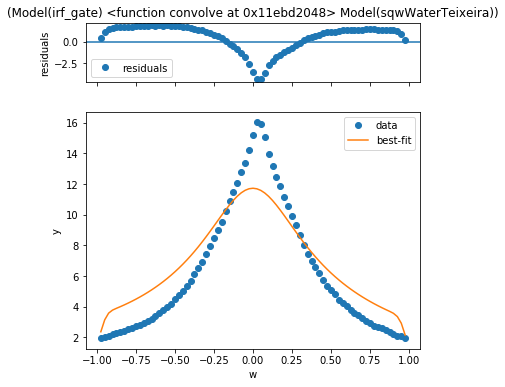

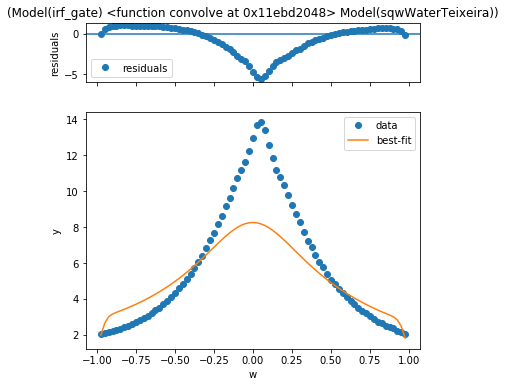

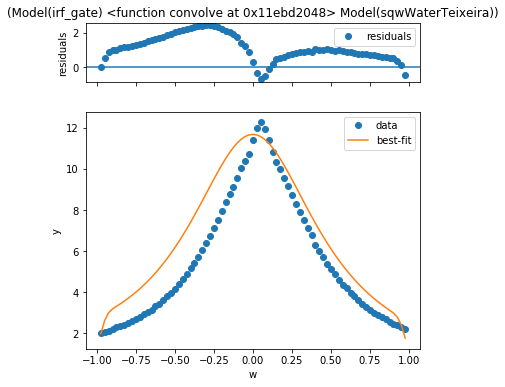

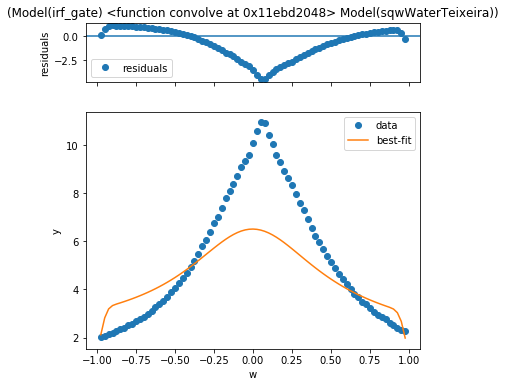

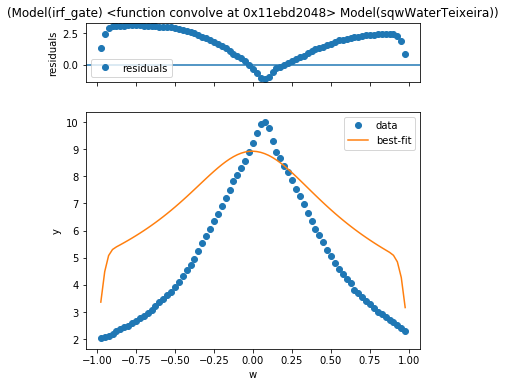

In [45]:
# plot results using lmfit's features
for i in range(nb_q_values):
    result_fit[i].plot()

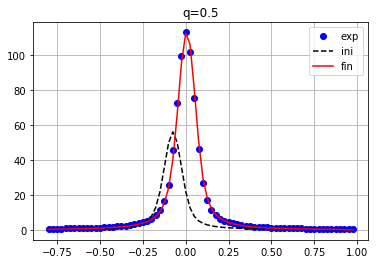

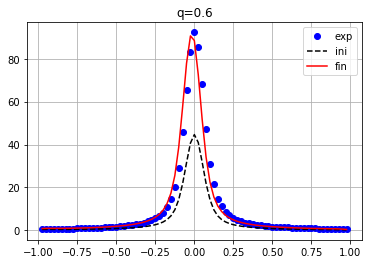

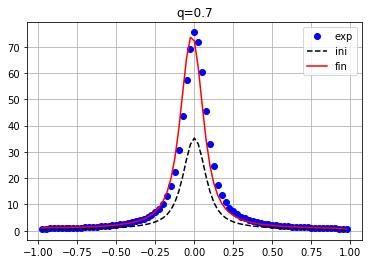

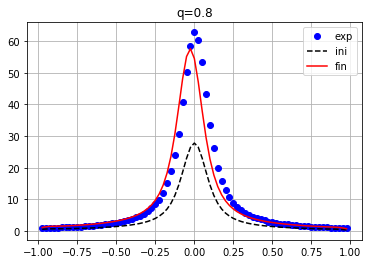

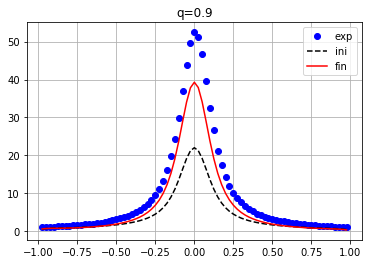

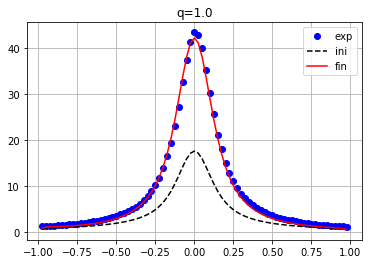

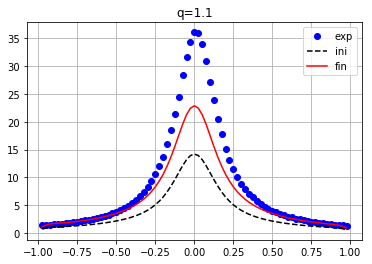

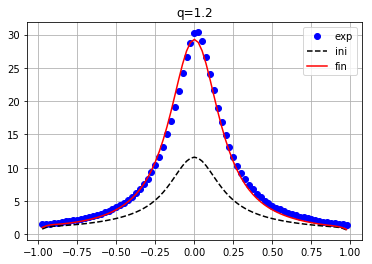

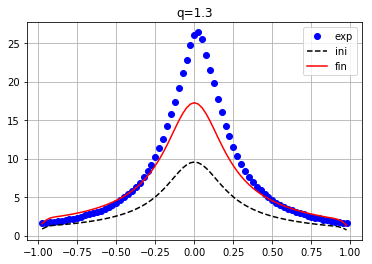

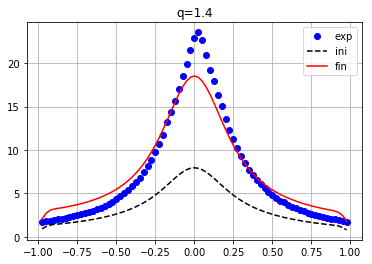

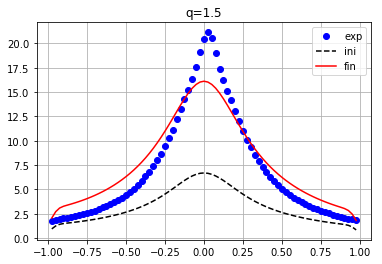

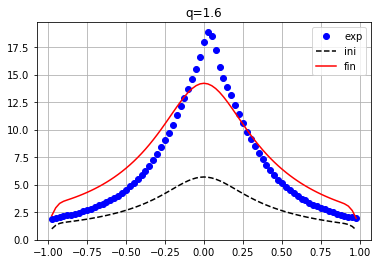

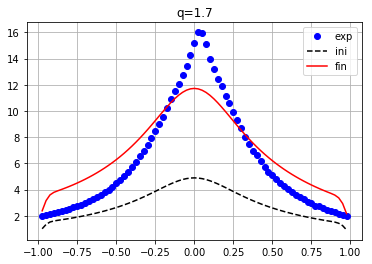

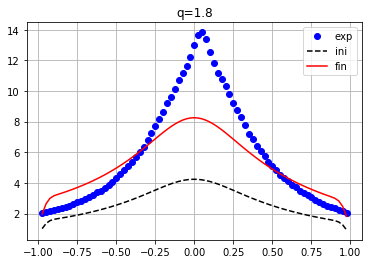

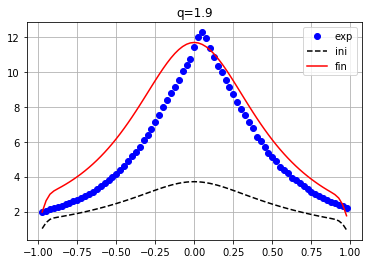

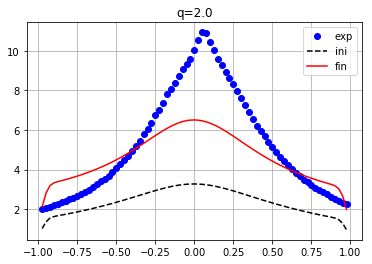

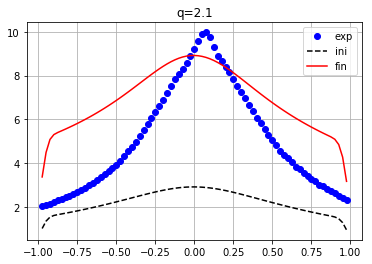

In [47]:
# other option to plot: experimental data, initial fitting model and fitted model for each spectrum
for indx in range(nb_q_values):
    plt.plot(f_5A['x'][indx], f_5A['y'][indx], 'bo',label='exp')
    plt.plot(f_5A['x'][indx], result_fit[indx].init_fit, 'k--',label='ini')
    plt.plot(f_5A['x'][indx], result_fit[indx].best_fit, 'r-', label='fin')
    plt.title("q={:.2}".format(data_5A['q'][indx]))
    plt.legend()
    plt.grid()
    plt.show()